In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

## Constants

In [3]:
vocab_size = 257
embedding_size = 5
hidden_units = 10
batch_size = 5
GO = 256
END = 257
image_dim = 28
image_grid_flat = 784
D_hidden_1 = 100
D_out = 1
generator_length = tf.constant(image_grid_flat, dtype=tf.int32)

## Generator

In [4]:
with tf.name_scope("generator"):
    embeddings = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="embeddings")

    go_time_slice = tf.ones([batch_size], dtype=tf.int32) * 256
    end_time_slice = tf.ones([batch_size], dtype=tf.int32) * 257
    go_embedding = tf.nn.embedding_lookup(embeddings, go_time_slice)
    end_embedding = tf.nn.embedding_lookup(embeddings, end_time_slice)

    W = tf.Variable(tf.random_uniform([hidden_units, vocab_size], -1.0, 1.0), name="W")
    b = tf.Variable(tf.random_uniform([vocab_size]), name="b")

    cells = tf.nn.rnn_cell.BasicLSTMCell(hidden_units)
    init_state = cells.zero_state(batch_size, dtype=tf.float32)

    def loop_initial():
        initial_elements_finished = (0 >= generator_length)
        initial_input = go_embedding
        initial_cell_state = init_state
        initial_cell_output = None
        initial_loop_state = None

        return (initial_elements_finished,
               initial_input,
               initial_cell_state, initial_cell_output,
               initial_loop_state)

    def loop_transition(time, previous_output, previous_state, previous_loop_state):
        def get_next_input():
            output_logits = tf.matmul(previous_output, W) + b
            prediction = tf.argmax(output_logits, axis = 1)
            next_input = tf.nn.embedding_lookup(embeddings, prediction)
            return next_input

        elements_finished = (time >= generator_length)
        finished = tf.reduce_all(elements_finished)
        ninput = tf.cond(finished, lambda: end_embedding, get_next_input)
        state = previous_state
        output = previous_output
        loop_state = None

        return (finished, ninput, state, output, loop_state)

    def loop_fn(time, poutput, pstate, ploop):
        if pstate is None:
            return loop_initial()
        else:
            return loop_transition(time, poutput, pstate, ploop)

    def generator():
        outputs_ta, _, _ = tf.nn.raw_rnn(cells, loop_fn)

        generator_outputs = outputs_ta.stack()

        gen_max_time, gen_batch_size, gen_dim = tf.unstack(tf.shape(generator_outputs))
        gen_outs_flats = tf.reshape(generator_outputs, (-1, gen_dim))
        gen_logits_flat = tf.matmul(gen_outs_flats, W) + b
        gen_logits = tf.reshape(gen_logits_flat, (gen_max_time, gen_batch_size, vocab_size))

        return tf.argmax(gen_logits, axis=2)

## Discriminator

In [5]:
with tf.name_scope("discriminator"):
    x_in = tf.placeholder("float", [None, image_grid_flat])
    
    D_W1 = tf.Variable(tf.random_uniform([image_grid_flat, D_hidden_1], -1.0, 1.0))
    D_b1 = tf.Variable(tf.random_uniform([D_hidden_1], -1.0, 1.0))
    
    D_W2 = tf.Variable(tf.random_uniform([D_hidden_1, D_out], -1.0, 1.0))
    D_b2 = tf.Variable(tf.random_uniform([D_out], -1.0, 1.0))
    
    theta_D = [D_W1, D_W2, D_b1, D_b2]
    
    def discriminator(x):
        l1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
        output = tf.nn.sigmoid(tf.matmul(l1, D_W2) + D_b2)
        
        return output

## Running generator and then Full genrator-discriminator

In [6]:
sample = generator()
real_fake = discriminator(x_in)
sess.run(tf.global_variables_initializer())
ans = sess.run(sample)
val = ans.T.reshape((batch_size, image_grid_flat))
sess.run(real_fake, feed_dict={x_in : val})

array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.]], dtype=float32)

## Visualizing one output of generator

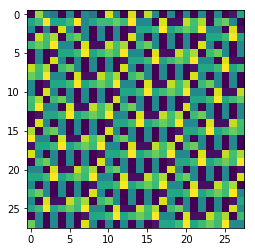

In [7]:
plt.imshow(val.reshape((batch_size, image_dim, image_dim))[0])

In [8]:
sess.close()